# Load Library

In [51]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import wandb
from tqdm import tqdm
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd
from base.dgd.latent import RepresentationLayer
from base.engine.predict import learn_new_representation #, learn_new_representation_mrna
from base.plotting.plot_cv2 import plot_latent_space, plot_gene, plot_mirna
from sklearn.metrics import root_mean_squared_error

In [52]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Data

In [53]:
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])
sample_annot = pd.read_table("data/TCGA_sample_anno_iso_match.tsv", sep='\t', index_col=[0])
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

In [104]:
def filter_sample_type(df):
    return df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]

filtered_annot = filter_sample_type(sample_annot)

filtered_annot.groupby('sample_type')['sample_id'].nunique()

sample_type
Primary Blood Derived Cancer - Peripheral Blood     173
Primary Tumor                                      9458
Solid Tissue Normal                                 619
Name: sample_id, dtype: int64

In [109]:
filtered_annot[filtered_annot['primary_site'].isna()]

,sample_id,cancer_type,sample_submitter_id,cancer_name,primary_site,sample_type,id_match,tissue_type,tumor_descriptor,age_at_index,gender,vital_status,tissue_or_organ_of_origin,color
614,TCGA-AB-2855-03A-01T-0736-13,LAML,TCGA-AB-2855-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,f372b31d-c8bc-40c6-82e2-c20e3c72368d,Tumor,Primary,18,male,Dead,Bone marrow,#744C27
618,TCGA-AB-2811-03B-01T-0760-13,LAML,TCGA-AB-2811-03B,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,cb679541-5009-419b-bf2b-284f138f7152,Tumor,Primary,81,male,Dead,Bone marrow,#744C27
625,TCGA-AB-2834-03A-01T-0734-13,LAML,TCGA-AB-2834-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,40cc6379-0f65-402e-b2fc-9e0474f3ac50,Tumor,Primary,33,male,Dead,Bone marrow,#744C27
626,TCGA-AB-2820-03A-01T-0735-13,LAML,TCGA-AB-2820-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,36143be8-45dd-426a-9741-b98f51160181,Tumor,Primary,76,male,Dead,Bone marrow,#744C27
627,TCGA-AB-2857-03A-01T-0736-13,LAML,TCGA-AB-2857-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,7a906712-cbad-453e-b025-67d7cc723a4e,Tumor,Primary,54,male,Dead,Bone marrow,#744C27
629,TCGA-AB-2856-03A-01T-0736-13,LAML,TCGA-AB-2856-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,0960c943-f12e-4b7b-9462-47e01af1204c,Tumor,Primary,63,male,Dead,Bone marrow,#744C27
631,TCGA-AB-2838-03A-01T-0736-13,LAML,TCGA-AB-2838-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,35ad1251-5b9e-4d9f-8580-0bf928b8f89e,Tumor,Primary,67,male,Dead,Bone marrow,#744C27
632,TCGA-AB-2866-03A-01T-0736-13,LAML,TCGA-AB-2866-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,b7f347b7-7fa4-4077-9f51-aa667151165c,Tumor,Primary,67,male,Dead,Bone marrow,#744C27
637,TCGA-AB-3000-03A-01T-0736-13,LAML,TCGA-AB-3000-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,4c89351a-7413-4088-8845-975af5b872a5,Tumor,Primary,25,male,Alive,Bone marrow,#744C27
639,TCGA-AB-2843-03A-01T-0736-13,LAML,TCGA-AB-2843-03A,ACUTE MYELOID LEUKEMIA,NaN,Primary Blood Derived Cancer - Peripheral Blood,20125821-1aff-4222-8e62-25cf6d648843,Tumor,Primary,77,male,Dead,Bone marrow,#744C27


In [115]:
filtered_annot.groupby('primary_site')['sample_id'].nunique()

primary_site
Adrenal Gland     261
Bile Duct          45
Bladder           422
Bone Marrow       121
Brain             509
Breast           1171
Cervix            307
Colorectal        604
Esophagus         196
Eye                80
Head and Neck     541
Kidney            978
Liver             417
Lung             1036
Lymph Nodes        47
Ovary             418
Pancreas          182
Pleura             87
Prostate          545
Skin               98
Soft Tissue       257
Stomach           445
Testis            134
Thymus            122
Thyroid           563
Uterus            609
Name: sample_id, dtype: int64

In [55]:
def data_filtering(df, filter_zero=True, filter_tumor=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]
        
    return df

# make data split for train, validation, and test sets
train_ratio= 0.7
# Train, val, and test data loaders
batch_size = 128

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

# Shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

# color mapping
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

data_loader = train_loader, validation_loader, test_loader

In [56]:
# make data split for train and validation sets
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

print(tcga_mrna.shape)
print(tcga_mirna.shape)
print(mrna_out_dim)
print(mirna_out_dim)

(10250, 19745)
(10250, 2028)
19741
2024


In [57]:
# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

print(mirna_column)

['hsa-let-7a-5p' 'hsa-let-7a-2-3p' 'hsa-let-7b-5p' ... 'hsa-miR-3168'
 'hsa-miR-3119' 'hsa-miR-6823-3p']


In [58]:
palette = dict(zip(train_mirna['cancer_type'], train_mirna['color']))
print(palette)

{'LGG': '#D49DC6', 'HNSC': '#97D1A9', 'BLCA': '#F9D2DB', 'OV': '#DA7D27', 'PRAD': '#7F1717', 'CESC': '#F7B666', 'MESO': '#542C88', 'KIRC': '#F8AEB2', 'COAD': '#9EDCF8', 'BRCA': '#ED1E91', 'UCEC': '#FBE3C7', 'KIRP': '#EB6F76', 'THCA': '#F4ED2F', 'LUSC': '#A084BD', 'LAML': '#744C27', 'LIHC': '#CACDDD', 'ACC': '#CCAB8E', 'SARC': '#00A99D', 'LUAD': '#D2C3DF', 'ESCA': '#007DB4', 'READ': '#DAF1FC', 'PCPG': '#E7C41D', 'TGCT': '#BE1D2C', 'UVM': '#0D9344', 'STAD': '#00AEEF', 'SKCM': '#BAD543', 'PAAD': '#6E7BA3', 'THYM': '#CCAB8E', 'CHOL': '#104A7F', 'KICH': '#EE1D23', 'DLBC': '#3953A4', 'UCS': '#F79420'}


# Load Model

In [59]:
dgd = torch.load('models/midgd-ms-filtered-0918.pth')

In [60]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


In [61]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=15, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): ZINB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
  (test_rep): RepresentationLayer()
)

## generate analysis data

In [62]:
def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

# Figure 1: Model Overview
1. Data overview
2. DGD overview
3. Training algorithm
4. Prediction algorithm

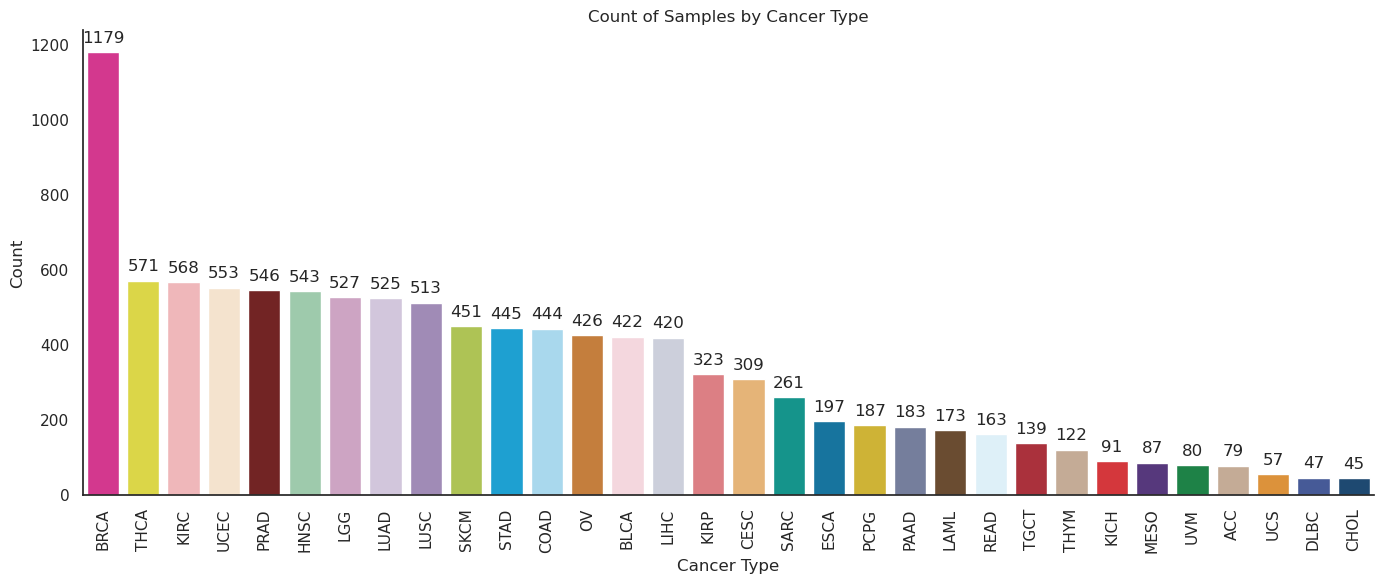

In [63]:
def barplot_dataset(df, savedir='plots', filename=None):
    color_mapping = dict(zip(df['cancer_type'], df['color']))

    primary_site_counts = df['cancer_type'].value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']

    sns.set_theme(style="white")
    # Create a bar plot
    plt.figure(figsize=(14, 6))
    barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
    plt.xlabel('Cancer Type')
    plt.ylabel('Count')
    plt.title('Count of Samples by Cancer Type')
    plt.xticks(rotation=90, ha='center')  # Rotate the x labels to show them more clearly
    
    # Annotate each bar with the count
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                         (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                         ha='center', va='center',  # Center the text horizontally and vertically
                         xytext=(0, 10),  # Offset the text by 10 points vertically
                         textcoords='offset points')  # Use offset points for the text coordinates
    
    plt.tight_layout()  # Adjust the layout to fit the x labels
    sns.despine()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

barplot_dataset(tcga_mrna_raw)

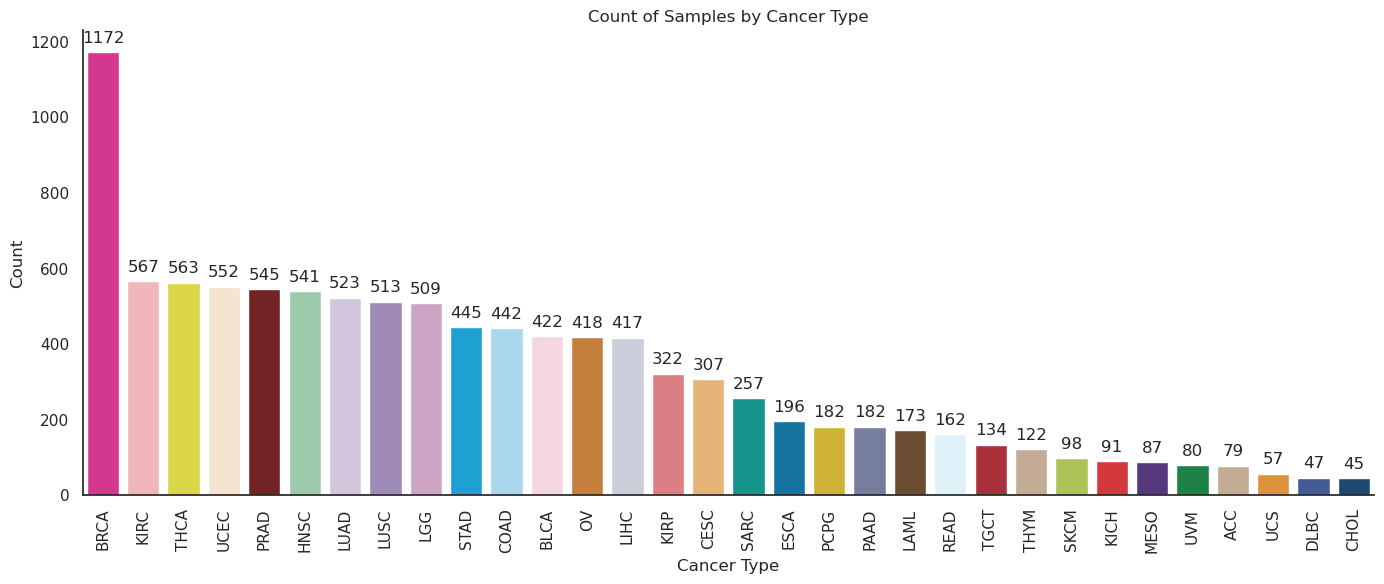

In [64]:
barplot_dataset(tcga_mrna, filename="barplot samples.svg")

## DGD Overview, Training, and Prediction

In drawio ;-)

# Figure 2: Latent space representations and cancer-type clustering

1. representation space PCA
2. GMM clustering heatmap

## Plot Latent Space

In [65]:
def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, title="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="white")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[10,5,30], 
                    edgecolor = "none", alpha=1, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("")
    ax[0].legend(loc='upper right', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=10,
                    edgecolor = "none", alpha=1, ax=ax[1], palette=color_mapping)
    ax[1].set_title("")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='x-small').remove()
    # Create a combined legend for the second subplot
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

    # plot
    plt.suptitle(f'PCA of {title}', fontsize=16)
    fig.supxlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    fig.supylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=8, markerscale=2, fontsize='small')
    # fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9), ncol=2, markerscale=3, fontsize='small')

    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

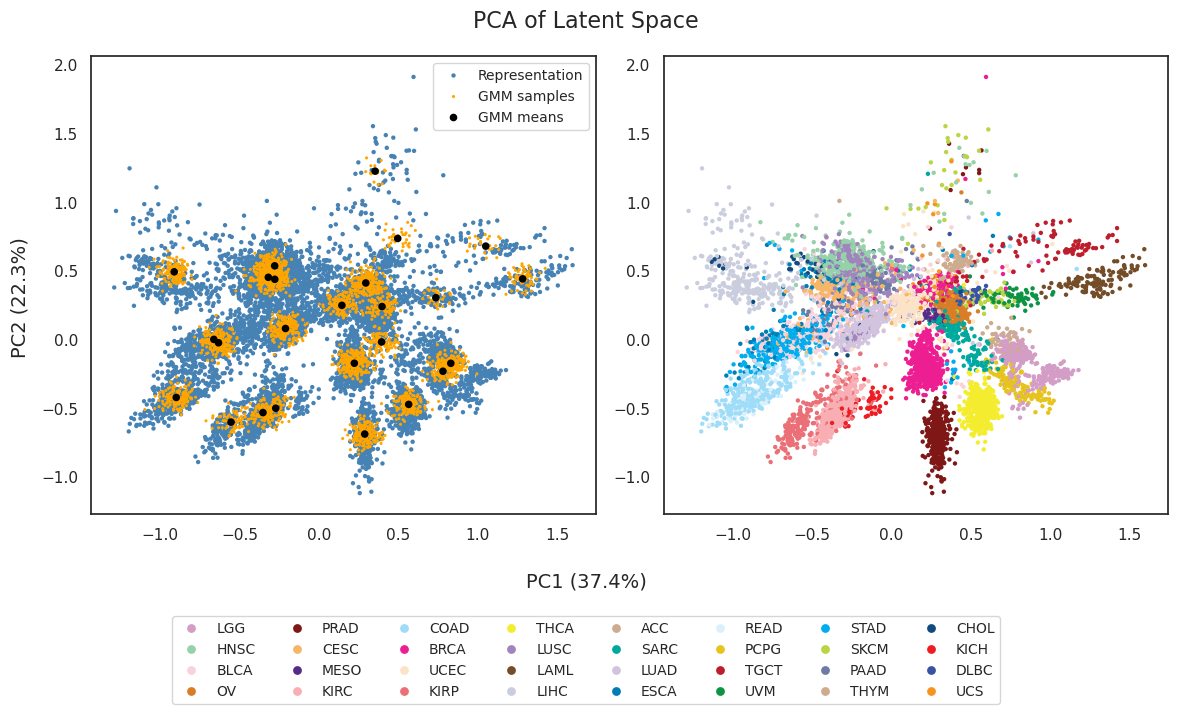

In [66]:
plot_latent_space(*dgd.get_latent_space_values("train",3000), 
                  dgd.gmm, train_loader.dataset.label, 
                  color_mapping, title="Latent Space",
                  filename="latent space pca - train.svg")

## GMM clustering

In [67]:
tissue_mapping = dict(zip(sample_annot['cancer_type'], sample_annot['primary_site']))
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

In [68]:
def gmm_clustering(dgd, rep):
    # if dataset == "train":
    #     rep = dgd.train_rep
    # elif dataset == "val":
    #     rep = dgd.val_rep
    # elif dataset == "test":
    #     rep = dgd.test_rep
        
    clustering = []
    for i in range(len(rep.z)):
        cluster = dgd.to(device).gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    clustering = np.array(clustering)
    
    return clustering

test_clustering = gmm_clustering(dgd, dgd.test_rep)
train_clustering = gmm_clustering(dgd, dgd.train_rep)

In [69]:
def gmm_clustering_plot(cluster, data_loader, tissue_mapping, is_save=False, savedir="plots", filename=None):
    gmm_comp = pd.DataFrame(
        data={
            'component': cluster,
            'cancer_type': data_loader.dataset.label
        }
    )
    
    # Create dataframe
    df = pd.crosstab(gmm_comp['cancer_type'], gmm_comp['component'])
    df = df.div(df.sum(axis=0))
    df['row_sum'] = df.sum(axis=1)
    df = df.sort_values(by='row_sum', ascending=False)
    df = df.drop(['row_sum'], axis=1)
    
    # Y label
    primary_site_counts = pd.Series(data_loader.dataset.label).value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']
    primary_site_counts = primary_site_counts.set_index('cancer_type')
    primary_site_counts = primary_site_counts.loc[df.index]
    primary_site_counts = primary_site_counts.reset_index()
    y_labels = [f"{cancer_type} ({count})" for cancer_type, count in zip(primary_site_counts['cancer_type'], primary_site_counts['count'])]
    
    # X label
    component_counts = pd.Series(cluster).value_counts().sort_index()
    
    # Determine the primary site with the highest count for each component
    primary_site_per_component = df.idxmax(axis=0).map(tissue_mapping)
    x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]
    
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    plt.subplots(figsize=(16, 10))
    annot = df.map(lambda x: f'{x:.2f}' if x >= 1e-2 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.7, annot_kws={'size': 9.5},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component', 'pad': 0.01})
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.xlabel("GMM components (#samples)", fontsize=12)
    plt.ylabel("Cancer Type (#samples)", fontsize=12)
    g.set_xticklabels(x_labels, fontsize=11, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10.5)
    plt.tight_layout()
    plt.title("GMM Clustering", fontsize=16)
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

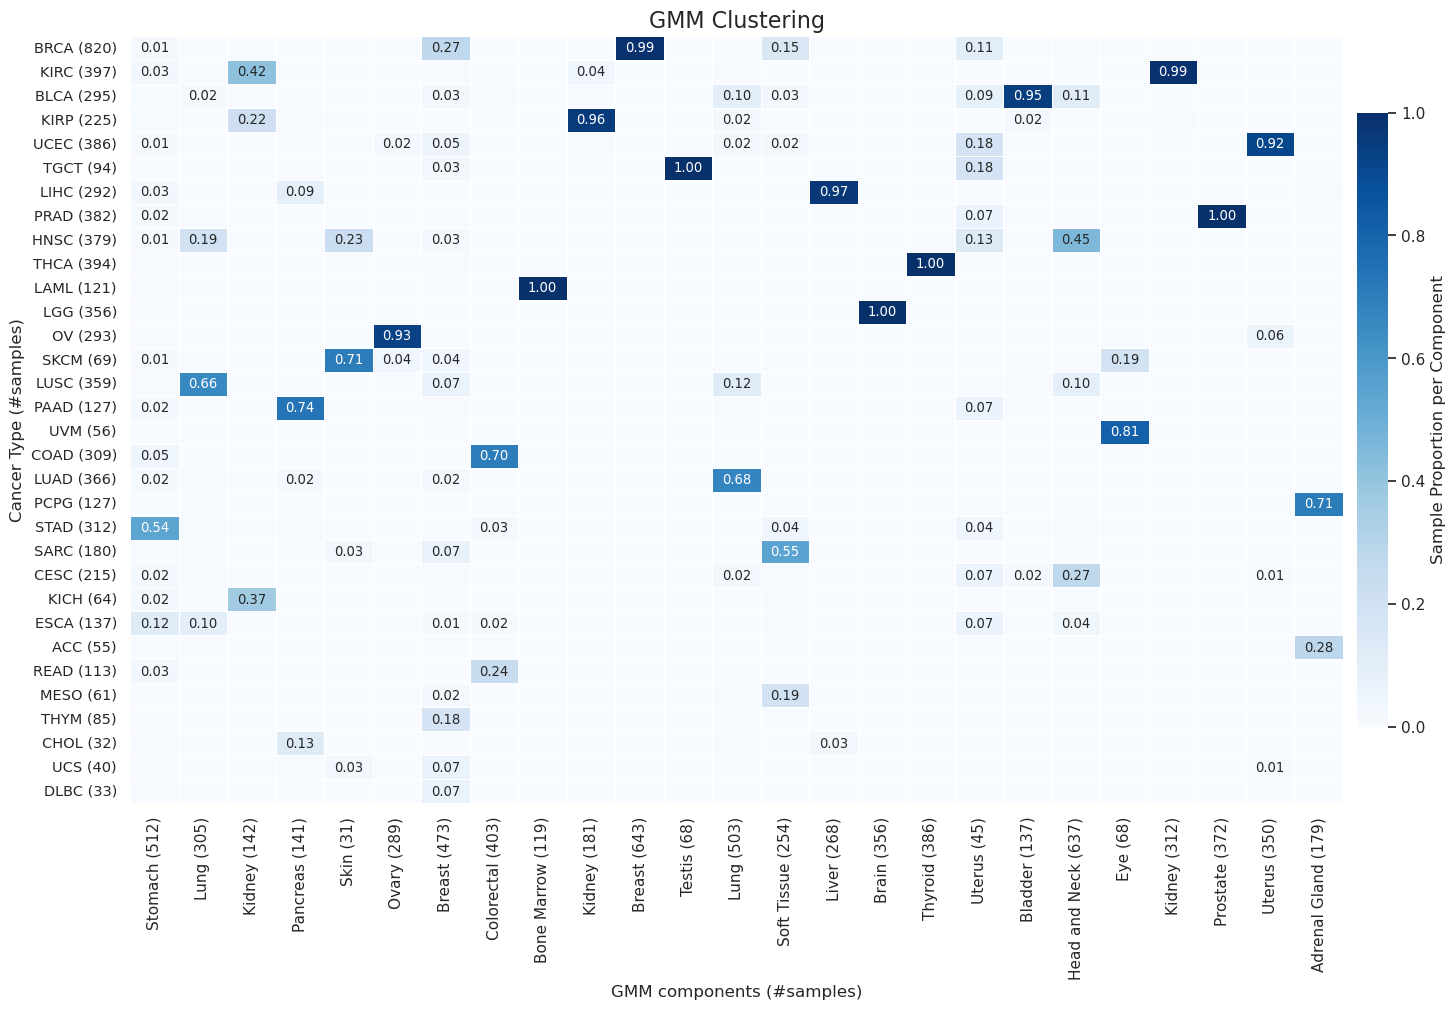

In [70]:
gmm_clustering_plot(train_clustering, train_loader, tissue_mapping, filename="gmm clustering train data.svg")

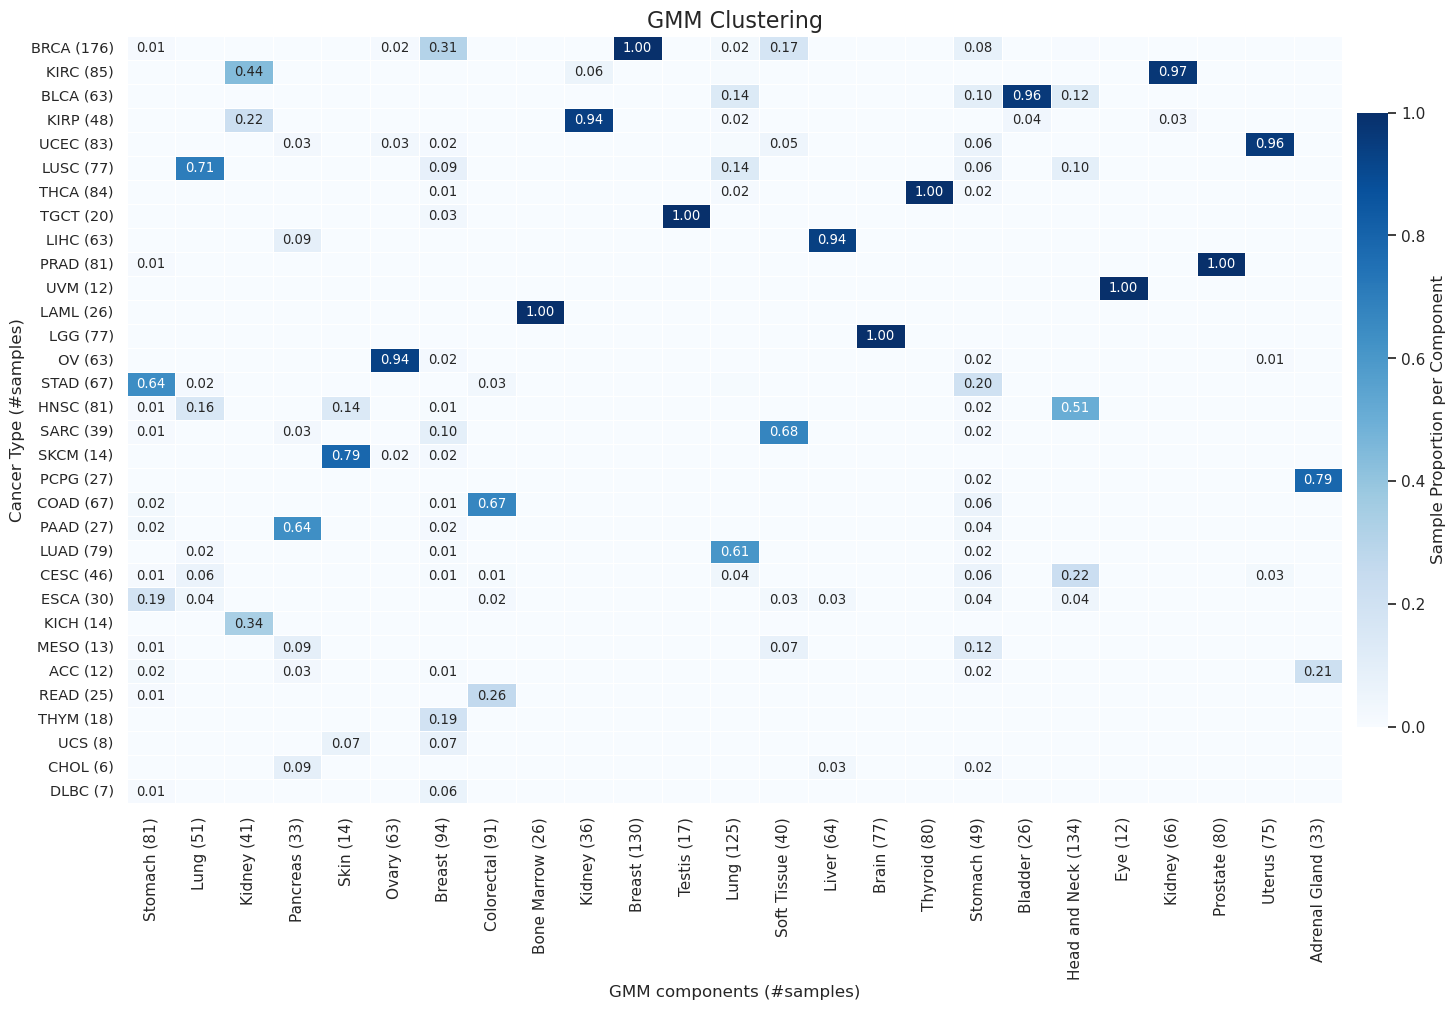

In [71]:
gmm_clustering_plot(test_clustering, test_loader, tissue_mapping, filename="gmm clustering test data.svg")

# Figure 3: Prediction of miRNA expression levels (examples and overall performance)

1. average correlation of expression level prediction
2. miR-example regression plot of all samples
3. miR-example regression plot tissue-specific
4. miR-example scatter plot per cancer type

## average correlation

In [72]:
def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

In [73]:
def plot_average_correlation(savedir='plots', filename='None'):
    sns.set_theme(style="whitegrid")
    sns.set_style("white")
    fig = plt.figure(figsize=(8,3))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=corr_data, x='spearman', bins=50)
    # plt.title("Spearman's Correlation")
    plt.xlabel("Spearman's Correlation")
    mean_spearman = corr_data['spearman'].mean()
    plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')
    
    plt.subplot(1,2,2)
    sns.histplot(data=corr_data, x='pearson', bins=50)
    # plt.title("Pearson's Correlation")
    plt.xlabel("Pearson's Correlation")
    plt.ylabel("")
    mean_pearson = corr_data['pearson'].mean()
    plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')
    
    # Add the main title to the figure
    # fig.suptitle("samples correlation histogram", fontsize=16)
    
    # Display the plots
    sns.despine()
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

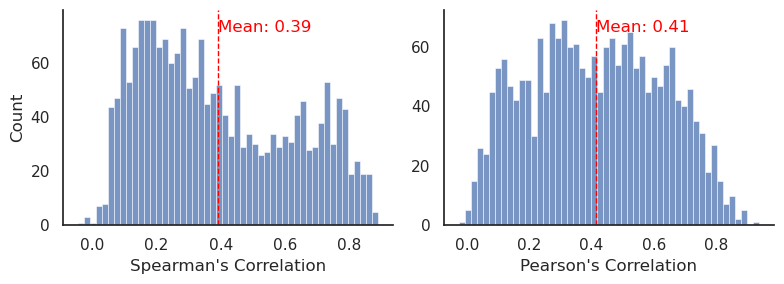

In [74]:
corr_data = calculate_corr(X_test, y_test, axis=0)
plot_average_correlation(corr_data, filename=None)

## regression

In [75]:
def regression_plot(subset, cancer_type=None, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")

    if cancer_type:
        test = test[test['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("white")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(4, 4))
    # plt.subplots_adjust(vspace=0.1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    if spearman_p < 2.2e-10:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-10", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    if pearson_p < 2.2e-10:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-10", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.xlabel("Predicted expression", fontsize=11)
    plt.ylabel("True expression", fontsize=11)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=10)

    # Add a small dashed diagonal line
    min_val = min(test['X'].min(), test['y'].min())
    max_val = max(test['X'].max(), test['y'].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', linewidth=0.5, color='black')
    
    if cancer_type:
        plt.title(f"{subset} in {cancer_type}", fontsize=12, y=1)
    else:
        plt.title(f"{subset} expression", fontsize=12, y=1)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

In [89]:
mir = 'hsa-miR-122-5p'
cancer = 'LIHC'

## miRNA regression plot all samples

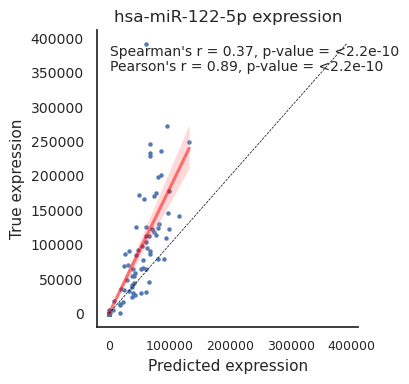

In [90]:
regression_plot(mir, filename=f"regplot {mir}.svg")

## miRNA regression plot tissue-specific

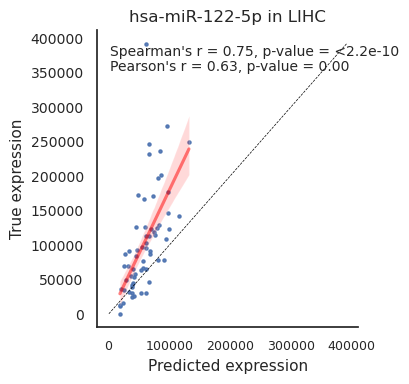

In [91]:
regression_plot(mir, cancer, filename=f"regplot {mir} in {cancer}.svg")

## miRNA scatter plot per cancer type

In [92]:
def plot_jitter_grouped_tissue(subset, savedir="plots", filename=None):
    data = get_mirna_data(dgd, data_loader, subset=subset)

    # Calculate RMSE
    rmse = root_mean_squared_error(data['y'], data['X'])
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    sns.boxplot(data=data, x="cancer_type", y="y", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[0])
    sns.stripplot(data=data, x="cancer_type", y="y", hue="tissue", alpha=0.8, zorder=0, ax=axes[0])
    axes[0].set_title("")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("True expression", fontsize=12)
    axes[0].set_xticks([])
    axes[0].tick_params(axis='y', labelsize=10)
    axes[0].legend(fontsize=8)

    # Annotate RMSE
    axes[0].text(0.01, 0.95, f'RMSE: {rmse:.2f}', 
                 horizontalalignment='left', 
                 verticalalignment='top', 
                 transform=axes[0].transAxes, 
                 fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.5))
    
    sns.boxplot(data=data, x="cancer_type", y="X", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[1])
    sns.stripplot(data=data, x="cancer_type", y="X", hue="tissue", alpha=0.9, zorder=0, ax=axes[1])
    axes[1].set_title("")
    axes[1].set_xlabel("Cancer Type", fontsize=12)
    axes[1].set_ylabel("Predicted expression", fontsize=12)
    axes[1].tick_params(axis='x', rotation=90, labelsize=12)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[1].legend(fontsize=8).remove()

    # Ensure x-tick labels are colored correctly
    for ax in axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_fontweight('normal')
            label.set_color(palette[cancer_type])
            
    fig.suptitle(f"{subset} expression", fontsize=14, y=0.95)
    sns.despine(bottom=False)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

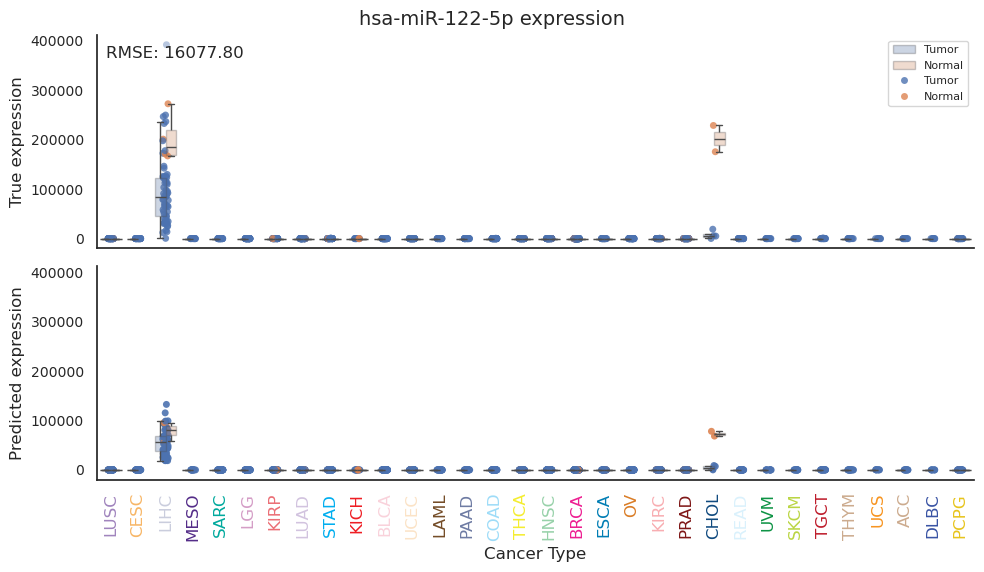

In [93]:
plot_jitter_grouped_tissue(mir, filename=f"jitter {mir}.svg")

# Figure 4: Downsampled (to mimic scRNA-seq) and actual scRNA-seq



1. downsampled regression plot miR-example
2. top correlating miRNA in various downsampled data

## prepare downsampled data

mnt_path = '/home/farzamani/'
project_path = os.path.join(mnt_path, "jsp_student_projects/miRNA_DGD_Farhad_F2024/")
data_path = os.path.join(project_path, "miDGD/data/downsampled/")

sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

test_datasets = []
test_loaders = []
test_rep_sparse = []
batch_size = 128

sparse_mrna_test = torch.load("results/sparse_mrna_test.pt")

for i, sp in enumerate(sparsity):
    # Train, val, and test data loaders
    dataset = GeneExpressionDatasetCombined(sparse_mrna_test[i], test_mirna, scaling_type='mean')
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         num_workers=num_workers)
    test_datasets.append(dataset)
    test_loaders.append(loader)

    test_rep = learn_new_representation(dgd, loader, learning_rates=1e-2, weight_decay=1e-4, test_epochs=20)
    test_rep_sparse.append(test_rep)

torch.save(test_rep_sparse, "results/test_rep.pt")
torch.save(test_loaders, "results/test_loaders.pt")
print("Done!")

test_rep_load = torch.load("results/test_rep.pt")
test_loaders = torch.load("results/test_loaders.pt")

# Figure 5: Treating individual mRNA/miRNAs as missing and regulatory network inference

1. Show if miR-122-5p is perturbed, the target mRNA will also perturbed
